# Modeling

## Business Problem

South by Southwest wants a predictive model that can predict the sentiment of a tweet as either positive, negative, or neutral. They want to use this model on tweets about their event so they can better gauge what people are looking forward to and what they are upset about. This can help with planning events and advertising.

It is important for SXSW this model does not falsely identify tweets as either positive or negative so I will use F1 Score and Accuracy Score as the main metrics for evaluating this model.

In [1]:
# load libraries
import numpy as np
import pandas as pd

# nltk libraries 
import nltk
nltk.download('stopwords', quiet=True)
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# sklearn preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# sklearn metrics and validation
from sklearn.model_selection import cross_validate, cross_val_score,\
train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, \
f1_score, plot_roc_curve, recall_score, classification_report, \
roc_auc_score, make_scorer, plot_confusion_matrix, precision_score

# import xgboost
import xgboost

In [2]:
# load dataset
df = pd.read_csv('./data/tweets_clean.csv', index_col=0)

# look at data 
df.head()

,tweet_text,directed_at,sentiment,company,target,clean_tweet,hashtags,mentions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,negative,i have a 3g iphone after 3 hrs tweeting at it ...,#rise_austin #sxsw,@wesley83
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,positive,know about awesome ipad iphone app that you'll...,#sxsw,@jessedee @fludapp
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,positive,can not wait for 2 also they should sale them ...,#ipad #sxsw,@swonderlin
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,negative,i hope this year's festival isn't as crashy as...,#sxsw,@sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,positive,great stuff on fri marissa mayer google tim o'...,#sxsw,@sxtxstate


In [3]:
df.isna().sum()

tweet_text        0
directed_at       0
sentiment         0
company           0
target            0
clean_tweet       1
hashtags          3
mentions       3899
dtype: int64

In [4]:
# drop null value from clean_tweet
df.dropna(subset=['clean_tweet'], inplace=True)

### Helper Function

In [5]:
# function for printing out metrics and plots
def print_metrics(estimator, X, y):
    
    # plot confusion matrix
    plot_confusion_matrix(estimator,
                     X=X,
                     y_true=y,
                     display_labels=['Negative', 'Neutral', 'Positive'])
    
    # metrics
    y_pred = estimator.predict(X)

    print('Accuracy score:', round(accuracy_score(y, y_pred), 3))
    print('F1 score:', round(f1_score(y, y_pred, average='weighted'), 3))
    print('Precision score:', round(precision_score(y, y_pred, average='weighted'), 3))
    print('Recall score:', round(recall_score(y, y_pred, average='weighted'), 3))
#     print('ROC AUC score:', round(roc_auc_score(y, estimator.predict_proba(X)[:, 1],average='weighted', multi_class='ovo'), 3))

In [6]:
# scoring for cross validation
scoring = {'accuracy': make_scorer(accuracy_score),
            'f1_score': make_scorer(f1_score,average='weighted')}

In [7]:
# function to run cross validation on model
def print_cross_validate(estimator, X=None, y=None, kfolds=5):
    '''
    Perform cross-validation and prints the test and train scores. 
    '''
    # cross validation
    cv = cross_validate(estimator,
               X=X,
               y=y,
               cv=kfolds,
               scoring=scoring,
               return_train_score=True)
    
    # print scores of cross validation
    print(f"Mean train accuracy score: {round(cv['train_accuracy'].mean(), 3)}")
    print(f"Mean val accuracy score: {round(cv['test_accuracy'].mean(), 3)}")
    print(f"Mean train f1 score: {round(cv['train_f1_score'].mean(), 3)}")
    print(f"Mean val f1 score: {round(cv['test_f1_score'].mean(), 3)}")

### Train Test Split

In [8]:
# Set X and y
X = df[['clean_tweet','company','directed_at']]

# mapping target to -1, 0, 1
y = df['target'].map({'negative': -1, 'neutral': 0, 'positive': 1})

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [9]:
X_train.head()

,clean_tweet,company,directed_at
5450,rt apple opening temporary ipad 2 store to han...,Unknown,Unknown
3638,if you're looking for a space to set up meetin...,Unknown,Unknown
1566,apple to open temporary store friday in the sc...,Unknown,Unknown
9049,you can buy my used ipad and i'll pick one up ...,Unknown,Unknown
6322,rt more awesomeness apple is opening up a temp...,Apple,Apple


### Preprocessing

Setting up stopwords and regex patterns

In [10]:
# regex pattern
pattern = "([a-zA-Z0-9]+(?:'[a-z]+)?)"

# stop words
stopwords_list = stopwords.words('english')

# add to stop words
stopwords_list += ['link', 'rt']

## Dummy Model Classifier - Baseline

I'll first use DummyClassifier to set up my baseline model.

In [11]:
# preprocess data
reg_token = RegexpTokenizer(pattern)

# CountVectorizer
count_vec = CountVectorizer(stop_words=stopwords_list, max_features=50)

# fit transform train
X_train_vec = count_vec.fit_transform(X_train['clean_tweet'])
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(count_vec.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [12]:
X_train_vec

,amp,android,app,apple,apps,austin,called,check,circles,day,...,quot,see,social,store,sxsw,temporary,time,today,via,win
5450,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3638,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1566,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
9049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6322,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Accuracy score: 0.598
F1 score: 0.448
Precision score: 0.358
Recall score: 0.598


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


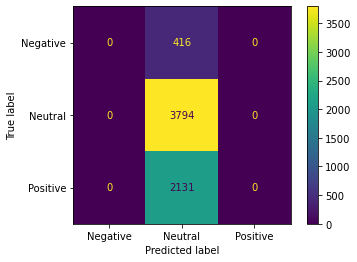

In [13]:
# dummy model pipeline
dum_pipe = Pipeline(steps=[
    ('count_vec', count_vec),
    ('dum', DummyClassifier(strategy='most_frequent'))
])

# fit pipeline with X_train
dum_pipe.fit(X_train['clean_tweet'], y_train)

# print metrics
print_metrics(dum_pipe, X_train['clean_tweet'], y_train)

In [14]:
# cross validate metrics
print_cross_validate(dum_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.598
Mean val accuracy score: 0.598
Mean train f1 score: 0.448
Mean val f1 score: 0.448


## Testing Multiple Models

### TF-IDF Vectorizer

In [15]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('tfidf', tfidf),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression()
Mean train accuracy score: 0.698
Mean val accuracy score: 0.646
Mean train f1 score: 0.666
Mean val f1 score: 0.61

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.63
Mean val accuracy score: 0.611
Mean train f1 score: 0.549
Mean val f1 score: 0.527

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.609
Mean val accuracy score: 0.605
Mean train f1 score: 0.471
Mean val f1 score: 0.464

MultinomialNB()
Mean train accuracy score: 0.678
Mean val accuracy score: 0.639
Mean train f1 score: 0.632
Mean val f1 score: 0.587

GradientBoostingClassifier()
Mean train accuracy score: 0.72
Mean val accuracy score: 0.651
Mean train f1 score: 0.677
Mean val f1 score: 0.592



In [16]:
# XGBoost pipeline
xg_pipe = Pipeline(steps=[
    ('tfidf', tfidf),
    ('xgb', xgboost.XGBClassifier(reg_lambda=40))
    ])

# fit pipeline
xg_pipe.fit(X_train['clean_tweet'], y_train)
print_cross_validate(xg_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.746
Mean val accuracy score: 0.653
Mean train f1 score: 0.715
Mean val f1 score: 0.611


### Count Vectorizer

In [17]:
# count vectorizer
count_vec = CountVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', count_vec),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.713
Mean val accuracy score: 0.65
Mean train f1 score: 0.692
Mean val f1 score: 0.623

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.631
Mean val accuracy score: 0.621
Mean train f1 score: 0.532
Mean val f1 score: 0.519

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.607
Mean val accuracy score: 0.606
Mean train f1 score: 0.468
Mean val f1 score: 0.465

MultinomialNB()
Mean train accuracy score: 0.653
Mean val accuracy score: 0.599
Mean train f1 score: 0.655
Mean val f1 score: 0.6

GradientBoostingClassifier()
Mean train accuracy score: 0.711
Mean val accuracy score: 0.66
Mean train f1 score: 0.667
Mean val f1 score: 0.605



In [18]:
# XGBoost pipeline
xg_pipe = Pipeline(steps=[
    ('count_vec', count_vec),
    ('xgb', xgboost.XGBClassifier(reg_lambda=40))
    ])

# fit pipeline
xg_pipe.fit(X_train['clean_tweet'], y_train)
print_cross_validate(xg_pipe, X_train['clean_tweet'], y_train)

Mean train accuracy score: 0.718
Mean val accuracy score: 0.661
Mean train f1 score: 0.681
Mean val f1 score: 0.616


## Initial Evaluation

CountVectorizer and TfIdfVectorizer are performing about the same. Getting validation scores in the high 60% and validation f1 scores in the low 60%. 

I am going to experiment with the following to see if it makes any improvements to the models:
* Add popular words to the stopwords list like apple, ipad, google, quot, store, and more from the EDA notebook.
* One hot encode the 'company' and 'directed_at' column.
* Use a combination of One Hot Encoder and Vectorizer.

Once I finish experimenting with these features I will run a gridsearch on the vectorizer using one of the better performing models. After that I will use the best parameters of the vectorizer and run a grid search on the best performing models to try and tune the hyperparameters to find an optimal model.

## Adding Additional Stopwords

### TF-IDF Vectorizer

In [19]:
# adding additional words to stopwords_list
new_stopwords_list = stopwords_list
new_stopwords_list += ['ipad', 'apple', 'google', 'store', 'iphone', 'quot']

In [20]:
# TfIdf Vectorizer
tfidf = TfidfVectorizer(stop_words=new_stopwords_list, max_features=500, ngram_range=(1,3), 
                        min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', tfidf),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.698
Mean val accuracy score: 0.642
Mean train f1 score: 0.666
Mean val f1 score: 0.606

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.635
Mean val accuracy score: 0.624
Mean train f1 score: 0.562
Mean val f1 score: 0.549

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.606
Mean val accuracy score: 0.605
Mean train f1 score: 0.465
Mean val f1 score: 0.463

MultinomialNB()
Mean train accuracy score: 0.682
Mean val accuracy score: 0.643
Mean train f1 score: 0.639
Mean val f1 score: 0.594

GradientBoostingClassifier()
Mean train accuracy score: 0.716
Mean val accuracy score: 0.65
Mean train f1 score: 0.673
Mean val f1 score: 0.594



### Count Vectorizer

In [21]:
# count vectorizer
count_vec = CountVectorizer(stop_words=new_stopwords_list, max_features=500, ngram_range=(1,3), min_df=5)

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('count_vec', count_vec),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train['clean_tweet'], y_train)
    print(model)
    print_cross_validate(pipe, X_train['clean_tweet'], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.709
Mean val accuracy score: 0.647
Mean train f1 score: 0.687
Mean val f1 score: 0.617

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.631
Mean val accuracy score: 0.62
Mean train f1 score: 0.549
Mean val f1 score: 0.536

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.607
Mean val accuracy score: 0.605
Mean train f1 score: 0.467
Mean val f1 score: 0.463

MultinomialNB()
Mean train accuracy score: 0.663
Mean val accuracy score: 0.611
Mean train f1 score: 0.66
Mean val f1 score: 0.605

GradientBoostingClassifier()
Mean train accuracy score: 0.709
Mean val accuracy score: 0.66
Mean train f1 score: 0.665
Mean val f1 score: 0.606



The additional stop words did not seem to have any additional benefit to the model.

## One Hot Encoder 'company'

In [26]:
# function to turn series to dataframe
def series_to_dataframe(series):
    return pd.DataFrame(series)

# Function Transformer
series_FT = FunctionTransformer(series_to_dataframe)

In [28]:
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# company one hot encode
X_train_company = ohe_pipe.fit_transform(X_train['company'])
X_train_company = pd.DataFrame(X_train_company)

Accuracy score: 0.889
F1 score: 0.859
Precision score: 0.831
Recall score: 0.889
Mean train accuracy score: 0.889
Mean val accuracy score: 0.889
Mean train f1 score: 0.859
Mean val f1 score: 0.859


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


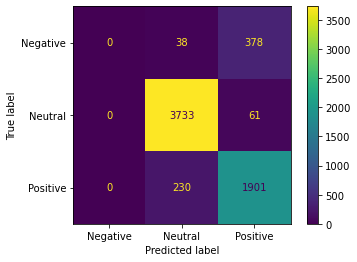

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train_company, y_train)
print_metrics(logreg, X_train_company, y_train)
print_cross_validate(logreg, X_train_company, y_train)

In [78]:
X_train.company.value_counts(normalize=True)

Unknown    0.630973
Apple      0.270304
Google     0.098723
Name: company, dtype: float64

### Evaluation

Using One Hot Encoder on the 'company' column performed much better than vectorizing the tweets. The logistic regression model achieved validation accuracy and f1 scores of 88.9% and 85.9% respectively. However, from the confusion matrix I can see the model did not predict negative at all on the train data. This is a problem as the model needs to be able to predict all three categories.

Next steps:
* One Hot Encode the 'directed_at' column and gauge performance.
* Train models using tweet vectorization and One Hot Encoder.

## One Hot Encoder on 'directed_at' column

In [31]:
# company one hot encode
X_train_product = ohe_pipe.fit_transform(X_train['directed_at'])
X_train_product = pd.DataFrame(X_train_product)
X_train_product

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6336,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6337,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6338,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6339,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
X_train.directed_at.value_counts()

Unknown                            4001
iPad                                676
Apple                               465
iPad or iPhone App                  332
Google                              300
iPhone                              216
Other Google product or service     212
Android App                          59
Android                              55
Other Apple product or service       25
Name: directed_at, dtype: int64

Accuracy score: 0.889
F1 score: 0.859
Precision score: 0.831
Recall score: 0.889


C:\Users\ghall\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean train accuracy score: 0.889
Mean val accuracy score: 0.889
Mean train f1 score: 0.859
Mean val f1 score: 0.859


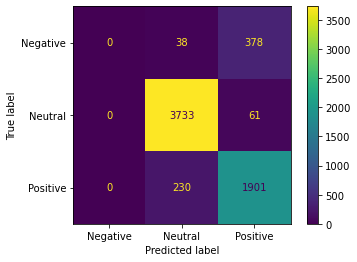

In [33]:
# instantiate and fit log reg
logreg = LogisticRegression()
logreg.fit(X_train_product, y_train)

# print training and validation
print_metrics(logreg, X_train_product, y_train)
print_cross_validate(logreg, X_train_product, y_train)

The model performed the exact same as the previous. This makes sense because the 'company' column is created from the 'directed_at' column

## One Hot Encode and TfIdf Vectorizer

### Testing the combination on Logistic Regression

In [34]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=500, ngram_range=(1,3))
# One hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['company'])
], remainder='passthrough')

# logreg pipeline
logreg_pipe = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [35]:
# fit logistic regression pipeline
logreg_pipe.fit(X_train[['clean_tweet', 'company']], y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vector_pipe',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001CD787BA160>)),
                                                                  ('vector',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   stop_words=['i',
                                                                                               'me',
                                                           

Accuracy score: 0.902
F1 score: 0.888
Precision score: 0.9
Recall score: 0.902


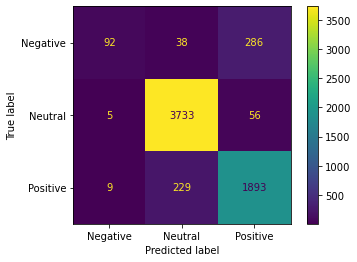

In [36]:
# print metrics of train data on logistic regression
print_metrics(logreg_pipe, X_train[['clean_tweet','company']],y_train)

In [37]:
# print cross val for train data on log reg pipeline 
print_cross_validate(logreg_pipe, X_train[['clean_tweet','company']],y_train)

Mean train accuracy score: 0.901
Mean val accuracy score: 0.894
Mean train f1 score: 0.886
Mean val f1 score: 0.875


### Running new pipeline on other models

In [38]:
# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['company'])
], remainder='passthrough')

# logreg pipeline
logreg_pipe = Pipeline(steps=[
    ('ct', CT),
    ('logreg', LogisticRegression(max_iter=1000))
])

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100)
#     AdaBoostClassifier(),
#     xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('ct', CT),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train[['clean_tweet', 'company']], y_train)
    print(model)
    print_cross_validate(pipe, X_train[['clean_tweet', 'company']], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.901
Mean val accuracy score: 0.894
Mean train f1 score: 0.886
Mean val f1 score: 0.875

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.896
Mean val accuracy score: 0.889
Mean train f1 score: 0.875
Mean val f1 score: 0.865

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.881
Mean val accuracy score: 0.878
Mean train f1 score: 0.851
Mean val f1 score: 0.848

MultinomialNB()
Mean train accuracy score: 0.894
Mean val accuracy score: 0.892
Mean train f1 score: 0.873
Mean val f1 score: 0.869

GradientBoostingClassifier()
Mean train accuracy score: 0.904
Mean val accuracy score: 0.89
Mean train f1 score: 0.89
Mean val f1 score: 0.868



## GridSearch on Vectorizer

Logistic Regression has been my best model so far so I am going to use it to GridSearch on the TF-IDF Vectorizer.

I will gridsearch the following parameters:
1. max_features
2. ngram_range
3. min_df

In [46]:
# setting parameters
params = {}

params['ct__vector_pipe__vector__max_features'] = [10 , 100, 500, 1000]
params['ct__vector_pipe__vector__ngram_range'] = [(1,1), (1,2), (1,3)]
params['ct__vector_pipe__vector__min_df'] = [1, 3, 5]

In [47]:
params

{'ct__vector_pipe__vector__max_features': [10, 100, 500, 1000],
 'ct__vector_pipe__vector__ngram_range': [(1, 1), (1, 2), (1, 3)],
 'ct__vector_pipe__vector__min_df': [1, 3, 5]}

In [48]:
# setting final X_train and X_test
X_train_final = X_train[['clean_tweet', 'company']]
X_test_final = X_test[['clean_tweet', 'company']]

In [49]:
# GridSearchCV on Log Reg
gs = GridSearchCV(logreg_pipe, params, cv=5, verbose=1, n_jobs=-1)

In [50]:
# fit GridSearch with train data
gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   34.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('vector_pipe',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001CD787BA160>)),
                                                                                         ('vector',
                                                                                          TfidfVectorizer(max_features=500,
                                                                                                          ngram_range=(1,
                                                                                                                       3),
                                  

In [54]:
# best params
print(gs.best_params_)
print(gs.best_score_)

{'ct__vector_pipe__vector__max_features': 1000, 'ct__vector_pipe__vector__min_df': 3, 'ct__vector_pipe__vector__ngram_range': (1, 3)}
0.8951270654505772


This estimator is really good. I do want to change the parameters more and change the max features.

In [57]:
# setting parameters
params = {}

params['ct__vector_pipe__vector__max_features'] = [500, 1000, 2000, 3000]
params['ct__vector_pipe__vector__ngram_range'] = [(1,1), (1,2), (1,3)]
params['ct__vector_pipe__vector__min_df'] = [1, 3, 5]

In [58]:
# GridSearchCV on Log Reg
gs = GridSearchCV(logreg_pipe, params, cv=5, verbose=1, n_jobs=-1)

In [59]:
# fit GridSearch with train data
gs.fit(X_train_final, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('vector_pipe',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001CD787BA160>)),
                                                                                         ('vector',
                                                                                          TfidfVectorizer(max_features=500,
                                                                                                          ngram_range=(1,
                                                                                                                       3),
                                  

In [60]:
# best params
print(gs.best_params_)
print(gs.best_score_)

{'ct__vector_pipe__vector__max_features': 3000, 'ct__vector_pipe__vector__min_df': 3, 'ct__vector_pipe__vector__ngram_range': (1, 2)}
0.8959154603962981


Accuracy score: 0.908
F1 score: 0.897
Precision score: 0.911
Recall score: 0.908
Mean train accuracy score: 0.907
Mean val accuracy score: 0.896
Mean train f1 score: 0.895
Mean val f1 score: 0.877


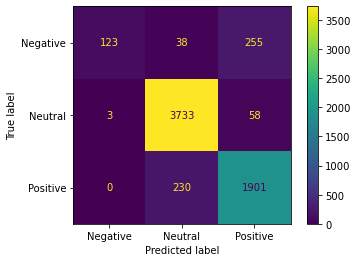

In [65]:
# print training metrics
print_metrics(gs.best_estimator_, X_train_final, y_train)

# print cross val scores
print_cross_validate(gs.best_estimator_, X_train_final, y_train)

This Logistic Regression model is performing really well on training and validation. I am going to use these parameters for TFIDF Vectorizer on the other models to see which one is best.

## Running models using GridSearched TF-IDF Vectorizer

In [67]:
# tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, max_features=3000, ngram_range=(1,2), min_df=3)

# pipeline for vectorizing
vector_pipe = Pipeline(steps=[
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', tfidf),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

# pipeline for TfIdf and One Hot Encoder
CT = ColumnTransformer(transformers=[
    ('vector_pipe', vector_pipe, ['clean_tweet']),
    ('ohe_pipe', ohe_pipe, ['company'])
], remainder='passthrough')

# list of models
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5),
    MultinomialNB(),    
    GradientBoostingClassifier(n_estimators=100),
    AdaBoostClassifier(),
    xgboost.XGBClassifier(reg_lambda=5.0)
]

# for loop to run through each model and print cross-val
for model in models:
    # steps for pipeline
    steps = [
    ('ct', CT),
    ('model', model)
    ]
    
    #pipeline
    pipe = Pipeline(steps)
    pipe.fit(X_train[['clean_tweet', 'company']], y_train)
    print(model)
    print_cross_validate(pipe, X_train[['clean_tweet', 'company']], y_train)
    print('')

LogisticRegression(max_iter=1000)
Mean train accuracy score: 0.907
Mean val accuracy score: 0.896
Mean train f1 score: 0.895
Mean val f1 score: 0.877

DecisionTreeClassifier(max_depth=5)
Mean train accuracy score: 0.897
Mean val accuracy score: 0.893
Mean train f1 score: 0.876
Mean val f1 score: 0.872

RandomForestClassifier(max_depth=5)
Mean train accuracy score: 0.636
Mean val accuracy score: 0.624
Mean train f1 score: 0.521
Mean val f1 score: 0.501

MultinomialNB()
Mean train accuracy score: 0.895
Mean val accuracy score: 0.893
Mean train f1 score: 0.873
Mean val f1 score: 0.869

GradientBoostingClassifier()
Mean train accuracy score: 0.904
Mean val accuracy score: 0.894
Mean train f1 score: 0.889
Mean val f1 score: 0.874

AdaBoostClassifier()
Mean train accuracy score: 0.888
Mean val accuracy score: 0.881
Mean train f1 score: 0.877
Mean val f1 score: 0.868

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gam

# Final Model - Logistic Regression

Our best model seems to be the Logistic Regression model used in the GridSearch. I am going to use this model as the final model as it is performing really well.

Let's see how it looks on test data.

In [74]:
# final model
final_model = gs.best_estimator_

Accuracy score: 0.908
F1 score: 0.897
Precision score: 0.911
Recall score: 0.908
Mean train accuracy score: 0.907
Mean val accuracy score: 0.896
Mean train f1 score: 0.895
Mean val f1 score: 0.877


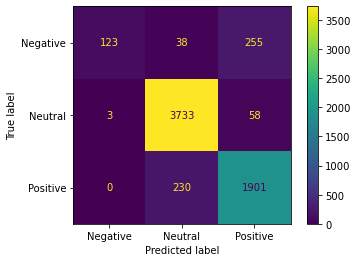

In [75]:
# fit final model on train data
final_model.fit(X_train_final, y_train)

# print metrics and cross validation
print_metrics(final_model, X_train_final, y_train)
print_cross_validate(final_model, X_train_final, y_train)

### Testing Final Model

Accuracy score: 0.902
F1 score: 0.884
Precision score: 0.896
Recall score: 0.902


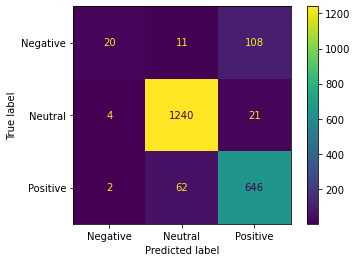

In [76]:
# test final model
print_metrics(final_model, X_test_final, y_test)

Overall, I am very happy with this model. 90% and 88% accuracy and f1 scores on test data. The confusion matrix is showing that it is predicting the negative class. However, it does mislabel the negative class often and this is probably due to the imbalance of the dataset.